Original code taken from [https://gist.github.com/EderSantana/c7222daa328f0e885093](https://gist.github.com/EderSantana/c7222daa328f0e885093)

# Installation
To be able to run the animation below, make sure you have the latest version of matplotlib, by running `python3 -m pip install matplotlib --upgrade`

In [1]:
%matplotlib inline
import json
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display

## Define the game environment and replay classes
The idea in this Catch game is that there is fruit falling, and the user gets to move a basket so that they catch the fruit. If they catch it, they win and the game is over. If they miss it, they lose and the game is over. We are trying to teach the computer to play this game.

In [2]:
class Catch(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_basket_center = 1
        self.max_basket_center = self.grid_size-2
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves basket according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, basket_center = self.state
        # move the basket unless this would move it off the edge of the grid
        new_basket_center = min(max(self.min_basket_center, basket_center + movement), self.max_basket_center)
        # move fruit down
        fruit_y += 1
        out = np.asarray([fruit_x, fruit_y, new_basket_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and basket and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, basket_center = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, basket_center-1:basket_center + 2] = 1  # draw 3-pixel basket
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the fruit was caught, -1 if it was dropped, and 0 if it is still in the air.
        '''
        fruit_x, fruit_y, basket_center = self.state
        if fruit_y == self.grid_size-1:
            if abs(fruit_x - basket_center) <= 1:
                return 1 # it caught the fruit
            else:
                return -1 # it dropped the fruit
        else:
            return 0 # the fruit is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if game is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        game_over = (reward != 0) # if the reward is zero, the fruit is still in the air
        return observation, reward, game_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            basket center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        basket_center = random.randint(self.min_basket_center, self.max_basket_center)
        self.state = np.asarray([fruit_x, fruit_y, basket_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            game_over: boolean
        Add the states and game over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            game_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i:i+1] = starting_observation
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if game_over: 
                # if the game is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the game is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets




##  Functions for creating, training, and visualizing the model

In [3]:
# parameters
epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10


def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(SGD(lr=.2), "mse")

    # Define environment/game
    env = Catch(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay


def train_model(model, env, exp_replay, num_episodes):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    for episode in range(num_episodes):
        reward = 0
        env.reset()
        game_over = False
        # get initial input
        starting_observation = env.observe()

        while not game_over:
            # get next action
            if np.random.rand() <= epsilon:
                # epsilon of the time, we just choose randomly
                action = np.random.randint(0, num_actions, size=1)
            else:
                # find which action the model currently thinks is best from this state
                q = model.predict(starting_observation)
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            new_observation, reward, game_over = env.act(action)

            # store experience
            exp_replay.remember([starting_observation, action, reward, new_observation], game_over)

            starting_observation = new_observation # for next time through the loop
            
        # get data updated based on the stored experiences
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

        # train model on the updated data
        loss = model.train_on_batch(inputs, targets)          

        # Print update from this episode
        print("Episode {:04d}/{:04d} | Loss {:.4f} | Reward {}".format(episode, num_episodes-1, loss, reward))


def create_animation(model, env, num_games):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_games: integer, the number of games to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the games and collect all of the images for each observed state
    observations = []
    for _ in range(num_games):
        env.reset()
        observation = env.observe()
        observations.append(observation)
        game_over = False
        while game_over == False:
            q = model.predict(observation)
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, game_over = env.act(action)
            observations.append(observation)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

## Let's create our model and game environment and see how it does before training

In [4]:
model, env, exp_replay = build_model()

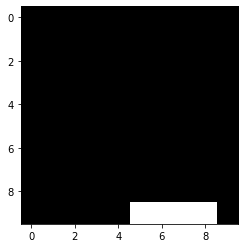

In [5]:
animation = create_animation(model, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

## Now train the model and see how much better it is at catching the fruit

Episode 0000/0999 | Loss 0.0450 | Reward -1
Episode 0001/0999 | Loss 0.0212 | Reward 1
Episode 0002/0999 | Loss 0.0274 | Reward -1
Episode 0003/0999 | Loss 0.0283 | Reward 1
Episode 0004/0999 | Loss 0.0085 | Reward 1
Episode 0005/0999 | Loss 0.0374 | Reward 1
Episode 0006/0999 | Loss 0.0279 | Reward -1
Episode 0007/0999 | Loss 0.0251 | Reward 1
Episode 0008/0999 | Loss 0.0146 | Reward -1
Episode 0009/0999 | Loss 0.0143 | Reward -1
Episode 0010/0999 | Loss 0.0432 | Reward -1
Episode 0011/0999 | Loss 0.0548 | Reward -1
Episode 0012/0999 | Loss 0.0338 | Reward -1
Episode 0013/0999 | Loss 0.0358 | Reward -1
Episode 0014/0999 | Loss 0.0336 | Reward -1
Episode 0015/0999 | Loss 0.0271 | Reward -1
Episode 0016/0999 | Loss 0.0243 | Reward 1
Episode 0017/0999 | Loss 0.0259 | Reward -1
Episode 0018/0999 | Loss 0.0258 | Reward -1
Episode 0019/0999 | Loss 0.0327 | Reward -1
Episode 0020/0999 | Loss 0.0370 | Reward -1
Episode 0021/0999 | Loss 0.0268 | Reward -1
Episode 0022/0999 | Loss 0.0243 | Rewa

Episode 0188/0999 | Loss 0.0229 | Reward 1
Episode 0189/0999 | Loss 0.0233 | Reward -1
Episode 0190/0999 | Loss 0.0181 | Reward -1
Episode 0191/0999 | Loss 0.0487 | Reward -1
Episode 0192/0999 | Loss 0.0343 | Reward 1
Episode 0193/0999 | Loss 0.0291 | Reward -1
Episode 0194/0999 | Loss 0.0277 | Reward -1
Episode 0195/0999 | Loss 0.0354 | Reward -1
Episode 0196/0999 | Loss 0.0433 | Reward -1
Episode 0197/0999 | Loss 0.0210 | Reward -1
Episode 0198/0999 | Loss 0.0292 | Reward 1
Episode 0199/0999 | Loss 0.0420 | Reward -1
Episode 0200/0999 | Loss 0.0397 | Reward -1
Episode 0201/0999 | Loss 0.0253 | Reward -1
Episode 0202/0999 | Loss 0.0503 | Reward -1
Episode 0203/0999 | Loss 0.0663 | Reward -1
Episode 0204/0999 | Loss 0.0439 | Reward 1
Episode 0205/0999 | Loss 0.0356 | Reward -1
Episode 0206/0999 | Loss 0.0285 | Reward -1
Episode 0207/0999 | Loss 0.0207 | Reward -1
Episode 0208/0999 | Loss 0.0339 | Reward 1
Episode 0209/0999 | Loss 0.0158 | Reward 1
Episode 0210/0999 | Loss 0.0349 | Rewa

Episode 0376/0999 | Loss 0.0237 | Reward -1
Episode 0377/0999 | Loss 0.0254 | Reward -1
Episode 0378/0999 | Loss 0.0318 | Reward 1
Episode 0379/0999 | Loss 0.0185 | Reward -1
Episode 0380/0999 | Loss 0.0188 | Reward -1
Episode 0381/0999 | Loss 0.0384 | Reward -1
Episode 0382/0999 | Loss 0.0328 | Reward -1
Episode 0383/0999 | Loss 0.0417 | Reward -1
Episode 0384/0999 | Loss 0.0254 | Reward 1
Episode 0385/0999 | Loss 0.0409 | Reward 1
Episode 0386/0999 | Loss 0.0335 | Reward -1
Episode 0387/0999 | Loss 0.0204 | Reward 1
Episode 0388/0999 | Loss 0.0364 | Reward 1
Episode 0389/0999 | Loss 0.0229 | Reward -1
Episode 0390/0999 | Loss 0.0231 | Reward 1
Episode 0391/0999 | Loss 0.0391 | Reward 1
Episode 0392/0999 | Loss 0.0415 | Reward -1
Episode 0393/0999 | Loss 0.0352 | Reward -1
Episode 0394/0999 | Loss 0.0335 | Reward -1
Episode 0395/0999 | Loss 0.0359 | Reward 1
Episode 0396/0999 | Loss 0.0297 | Reward -1
Episode 0397/0999 | Loss 0.0389 | Reward -1
Episode 0398/0999 | Loss 0.0246 | Reward

Episode 0564/0999 | Loss 0.0205 | Reward -1
Episode 0565/0999 | Loss 0.0154 | Reward -1
Episode 0566/0999 | Loss 0.0238 | Reward -1
Episode 0567/0999 | Loss 0.0243 | Reward -1
Episode 0568/0999 | Loss 0.0230 | Reward -1
Episode 0569/0999 | Loss 0.0272 | Reward -1
Episode 0570/0999 | Loss 0.0189 | Reward -1
Episode 0571/0999 | Loss 0.0111 | Reward -1
Episode 0572/0999 | Loss 0.0268 | Reward -1
Episode 0573/0999 | Loss 0.0328 | Reward 1
Episode 0574/0999 | Loss 0.0224 | Reward -1
Episode 0575/0999 | Loss 0.0256 | Reward -1
Episode 0576/0999 | Loss 0.0190 | Reward 1
Episode 0577/0999 | Loss 0.0189 | Reward -1
Episode 0578/0999 | Loss 0.0214 | Reward -1
Episode 0579/0999 | Loss 0.0266 | Reward -1
Episode 0580/0999 | Loss 0.0330 | Reward -1
Episode 0581/0999 | Loss 0.0335 | Reward -1
Episode 0582/0999 | Loss 0.0323 | Reward 1
Episode 0583/0999 | Loss 0.0202 | Reward 1
Episode 0584/0999 | Loss 0.0227 | Reward -1
Episode 0585/0999 | Loss 0.0220 | Reward 1
Episode 0586/0999 | Loss 0.0185 | Rew

Episode 0752/0999 | Loss 0.0382 | Reward -1
Episode 0753/0999 | Loss 0.0388 | Reward -1
Episode 0754/0999 | Loss 0.0217 | Reward -1
Episode 0755/0999 | Loss 0.0384 | Reward -1
Episode 0756/0999 | Loss 0.0292 | Reward -1
Episode 0757/0999 | Loss 0.0184 | Reward -1
Episode 0758/0999 | Loss 0.0311 | Reward 1
Episode 0759/0999 | Loss 0.0233 | Reward 1
Episode 0760/0999 | Loss 0.0319 | Reward -1
Episode 0761/0999 | Loss 0.0431 | Reward 1
Episode 0762/0999 | Loss 0.0222 | Reward 1
Episode 0763/0999 | Loss 0.0223 | Reward -1
Episode 0764/0999 | Loss 0.0410 | Reward -1
Episode 0765/0999 | Loss 0.0194 | Reward 1
Episode 0766/0999 | Loss 0.0145 | Reward 1
Episode 0767/0999 | Loss 0.0164 | Reward 1
Episode 0768/0999 | Loss 0.0050 | Reward 1
Episode 0769/0999 | Loss 0.0325 | Reward -1
Episode 0770/0999 | Loss 0.0303 | Reward -1
Episode 0771/0999 | Loss 0.0403 | Reward -1
Episode 0772/0999 | Loss 0.0141 | Reward -1
Episode 0773/0999 | Loss 0.0139 | Reward -1
Episode 0774/0999 | Loss 0.0221 | Reward

Episode 0940/0999 | Loss 0.0177 | Reward -1
Episode 0941/0999 | Loss 0.0059 | Reward -1
Episode 0942/0999 | Loss 0.0161 | Reward -1
Episode 0943/0999 | Loss 0.0112 | Reward -1
Episode 0944/0999 | Loss 0.0211 | Reward -1
Episode 0945/0999 | Loss 0.0117 | Reward -1
Episode 0946/0999 | Loss 0.0217 | Reward -1
Episode 0947/0999 | Loss 0.0250 | Reward -1
Episode 0948/0999 | Loss 0.0188 | Reward -1
Episode 0949/0999 | Loss 0.0094 | Reward -1
Episode 0950/0999 | Loss 0.0156 | Reward -1
Episode 0951/0999 | Loss 0.0126 | Reward -1
Episode 0952/0999 | Loss 0.0135 | Reward -1
Episode 0953/0999 | Loss 0.0132 | Reward 1
Episode 0954/0999 | Loss 0.0120 | Reward -1
Episode 0955/0999 | Loss 0.0154 | Reward 1
Episode 0956/0999 | Loss 0.0120 | Reward -1
Episode 0957/0999 | Loss 0.0246 | Reward -1
Episode 0958/0999 | Loss 0.0114 | Reward -1
Episode 0959/0999 | Loss 0.0258 | Reward 1
Episode 0960/0999 | Loss 0.0134 | Reward -1
Episode 0961/0999 | Loss 0.0116 | Reward 1
Episode 0962/0999 | Loss 0.0142 | Re

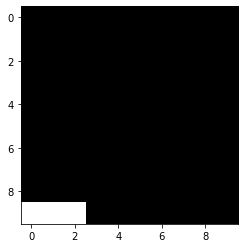

In [6]:
train_model(model, env, exp_replay, num_episodes=1000)
animation = create_animation(model, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

# Possible Exercises:
1. Add a validation function, to make it easier to assess models.
1. We've been looking at convolutional neural networks for image processing. Try changing the model to use convolutional layers. Does this seem to work any better?
1. Change the code so that the basket is trying to avoid getting hit by the fruit.
1. Change the code so the game keeps going until the basket misses the fruit. (To test that this is working, you may want to change the number of games in the animation to 1.) How should this change the rewards that the model gets?
1. Change the game to something entirely different.
1. Try changing how the training works (for instance, changing the discount rate or having the model always choose the action randomly weighted by the action values). Keep notes on what you observe as to how this changes the model performance.